# Main objective
To recommend a food business restaurant by location and to show where the main competitors are.

## How it works
This recommender uses offer, demand, satisfaction and trends to calculate a score.

* Offer <-- Inegi
* Demand <-- Google Trends
* Satisfaction <-- Yelp
* Trends <-- Google Trends Interest Over Time

#### Score = Demand + Trends - Offer - Satisfaction
Biggest score is the recommendation.

# Main libraries

In [2]:
from dotenv import load_dotenv
load_dotenv()

import os
import pandas as pd

# Inegi
In this section we are getting the offer.

We are using an Inegi database from https://inegi.org.mx/app/descarga/default.html

Currently, we are using a preprocessed database from an attached notebook.

In [3]:
def prepareInegi():
    inegi = pd.read_csv('inegi.csv')
    inegi.drop(columns=['nom_estab', 'per_ocu', 'fecha_alta', 'nom_processed', 'tipoUniEco', 'localidad'], inplace=True)
    return inegi

In [4]:
inegi = prepareInegi()
inegi.entidad.value_counts()

VERACRUZ DE IGNACIO DE LA LLAVE             48459
YUCATAN                                     17180
SAN LUIS POTOSÍ                             15655
TAMAULIPAS                                  15576
SINALOA                                     15321
SONORA                                      13198
QUERÉTARO                                   12448
TABASCO                                     11959
QUINTANA ROO                                11275
ZACATECAS                                    8474
TLAXCALA                                     8267
Name: entidad, dtype: int64

## Filtering by state and city

In [5]:
def getInegiByState(state):
    return inegi[inegi['entidad']==state]

### As use case for the demonstration we are selecting TAMAULIPAS

In [6]:
sinegi = getInegiByState('TAMAULIPAS')
sinegi.head()

,entidad,municipio,latitud,longitud,tipo,Cocina Económica,Antojitos,Pizza,Hamburguesas,Hot Dogs,...,Yucateca,Tabasqueña,Arrachera,Pastor,Birria,Barbacoa,Carnero,Pozole,Enchiladas,Chilaquiles
79856,TAMAULIPAS,Matamoros,25.869956,-97.514709,"['burg', 'burgu', 'hamburgues']",0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
79857,TAMAULIPAS,Altamira,22.391528,-97.930704,[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
79858,TAMAULIPAS,Valle Hermoso,25.670395,-97.815718,[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
79859,TAMAULIPAS,Victoria,23.729669,-99.152546,[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
79860,TAMAULIPAS,Altamira,22.334950,-97.865727,['restaur'],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
sinegi['municipio'].value_counts()

Matamoros             2384
Tampico               2161
Reynosa               1972
Nuevo Laredo          1757
Victoria              1550
Ciudad Madero         1156
Altamira              1053
El Mante               667
Río Bravo              542
Valle Hermoso          380
Miguel Alemán          222
González               211
San Fernando           171
Tula                   154
Aldama                 134
Camargo                109
Gustavo Díaz Ordaz     108
Xicoténcatl            104
Soto la Marina          95
Jaumave                 87
Padilla                 85
Ocampo                  74
Hidalgo                 61
Mier                    48
Antiguo Morelos         37
Llera                   36
Abasolo                 36
Jiménez                 30
Nuevo Morelos           29
Guerrero                27
Gómez Farías            27
Villagrán               11
Güémez                  11
San Carlos              10
Burgos                   9
Miquihuana               7
Mainero                  5
B

In [8]:
def inegiFilterByMunicipio(municipio, df):
    return df.drop(df[df['municipio']!=municipio].index)

### As use case we are selecting Tampico as the city

In [9]:
sinegi = inegiFilterByMunicipio('Tampico', sinegi)
sinegi.head()

,entidad,municipio,latitud,longitud,tipo,Cocina Económica,Antojitos,Pizza,Hamburguesas,Hot Dogs,...,Yucateca,Tabasqueña,Arrachera,Pastor,Birria,Barbacoa,Carnero,Pozole,Enchiladas,Chilaquiles
79866,TAMAULIPAS,Tampico,22.273236,-97.874833,[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
79867,TAMAULIPAS,Tampico,22.255264,-97.861039,['com'],1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
79868,TAMAULIPAS,Tampico,22.262607,-97.859094,['com'],1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
79874,TAMAULIPAS,Tampico,22.213607,-97.849838,[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
79885,TAMAULIPAS,Tampico,22.302357,-97.860012,[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Obtaining offer by food type

In [10]:
foods = ['Cocina Económica', 'Antojitos', 'Pizza', 'Hamburguesas', 'Hot Dogs', 'Sushi', 'Tamales', 'Mariscos', 
         'Pescado', 'Tacos', 'Carne', 'Asada', 'Panuchos', 'Cochinita', 'Pollo', 'Desayunos', 'Tortas', 'Mondongo', 
         'Menudo', 'Memelas', 'Empanadas', 'Chicharrón', 'Gorditas', 'Costillas', 'Carnitas', 'Doraditas', 
         'Baguettes', 'Parrilla', 'Huaraches', 'Rosticería', 'China', 'Yucateca', 'Tabasqueña', 'Arrachera', 
         'Pastor', 'Birria', 'Barbacoa', 'Carnero', 'Pozole', 'Enchiladas', 'Chilaquiles']

In [11]:
def getInegiResults(df):
    results = {}

    for food in foods:
        results[food] = df[food].sum()

    return results

In [12]:
inegi_results = getInegiResults(sinegi)
inegi_results

{'Cocina Económica': 185,
 'Antojitos': 156,
 'Pizza': 31,
 'Hamburguesas': 31,
 'Hot Dogs': 23,
 'Sushi': 2,
 'Tamales': 39,
 'Mariscos': 45,
 'Pescado': 11,
 'Tacos': 344,
 'Carne': 0,
 'Asada': 69,
 'Panuchos': 0,
 'Cochinita': 9,
 'Pollo': 113,
 'Desayunos': 2,
 'Tortas': 252,
 'Mondongo': 1,
 'Menudo': 0,
 'Memelas': 0,
 'Empanadas': 9,
 'Chicharrón': 1,
 'Gorditas': 111,
 'Costillas': 1,
 'Carnitas': 38,
 'Doraditas': 0,
 'Baguettes': 5,
 'Parrilla': 11,
 'Huaraches': 1,
 'Rosticería': 5,
 'China': 0,
 'Yucateca': 3,
 'Tabasqueña': 0,
 'Arrachera': 2,
 'Pastor': 10,
 'Birria': 0,
 'Barbacoa': 26,
 'Carnero': 0,
 'Pozole': 0,
 'Enchiladas': 1,
 'Chilaquiles': 1}

## Adding offer to the main dataframe df

In [13]:
def getInegiDfResult(inegi_results):
    return pd.DataFrame(inegi_results.items(), columns = ['Index', 'InegiCount']).set_index('Index')

In [14]:
df = getInegiDfResult(inegi_results)
df.head()

,InegiCount
Index,
Cocina Económica,185
Antojitos,156
Pizza,31
Hamburguesas,31
Hot Dogs,23


# Google Trends
In this section we are getting the demand.

We are using the Google Trends endpoint https://trends.google.com/trends by means of the Pytrends API https://pypi.org/project/pytrends/


We check the trending of each food type in Mexico. Google trends gives information by state.

In [15]:
from pytrends.request import TrendReq

In [16]:
def getGoogleTrends(df):
    pytrends = TrendReq(hl='es-MX', tz=360)
    
    resultados = []
    for comida in foods:
        print(comida)
        pytrends.build_payload([comida], cat=71, geo='MX', gprop='')
        resultados.append(pytrends.interest_by_region(resolution='REGION', inc_low_vol=True, inc_geo_code=False))
    return resultados

In [17]:
google_trends = getGoogleTrends(sinegi)
google_trends

Cocina Económica
Antojitos
Pizza
Hamburguesas
Hot Dogs
Sushi
Tamales
Mariscos
Pescado
Tacos
Carne
Asada
Panuchos
Cochinita
Pollo
Desayunos
Tortas
Mondongo
Menudo
Memelas
Empanadas
Chicharrón
Gorditas
Costillas
Carnitas
Doraditas
Baguettes
Parrilla
Huaraches
Rosticería
China
Yucateca
Tabasqueña
Arrachera
Pastor
Birria
Barbacoa
Carnero
Pozole
Enchiladas
Chilaquiles


[                      Cocina Económica
 geoName                               
 Aguascalientes                       0
 Baja California                      0
 Baja California Sur                  0
 Campeche                             0
 Chiapas                              0
 Chihuahua                            0
 Ciudad de México                    25
 Coahuila de Zaragoza                 0
 Colima                               0
 Durango                              0
 Estado de México                    25
 Guanajuato                           0
 Guerrero                             0
 Hidalgo                              0
 Jalisco                              0
 Michoacán                            0
 Morelos                              0
 Nayarit                              0
 Nuevo León                           0
 Oaxaca                               0
 Puebla                               0
 Querétaro                            0
 Quintana Roo                         0


### Filtering by state

In [18]:
def getTrends(google_trends, state):
    requests = google_trends[0].join(google_trends[1:]).T
    return requests[state].sort_values(ascending=False)

In [19]:
trends =  getTrends(google_trends, 'Tamaulipas')
trends

Tamales             100
Pollo                89
Carne                80
Gorditas             78
Menudo               73
Asada                67
Chicharrón           63
Pizza                62
Enchiladas           61
Hamburguesas         58
Empanadas            57
Pescado              55
Costillas            53
Carnitas             47
Desayunos            44
Mariscos             43
Pastor               42
Hot Dogs             40
Cochinita            40
Barbacoa             38
Chilaquiles          36
Arrachera            33
China                32
Mondongo             28
Tacos                27
Antojitos            27
Memelas              26
Pozole               24
Huaraches            23
Carnero              22
Tortas               22
Parrilla             17
Panuchos             11
Birria               11
Sushi                 8
Yucateca              2
Rosticería            0
Doraditas             0
Tabasqueña            0
Baguettes             0
Cocina Económica      0
Name: Tamaulipas

## Adding demand to the main dataframe df

In [20]:
df['GoogleTrend'] = trends
df

,InegiCount,GoogleTrend
Index,,
Cocina Económica,185,0
Antojitos,156,27
Pizza,31,62
Hamburguesas,31,58
Hot Dogs,23,40
Sushi,2,8
Tamales,39,100
Mariscos,45,43
Pescado,11,55


## Interest over time

In [21]:
def getGoogleIOT():
    pytrends = TrendReq(hl='es-MX', tz=360)
    iot = {}
    for comida in foods:
        print(comida)
        pytrends.build_payload([comida], cat=71, geo='MX', gprop='')
        iot[comida] = pytrends.interest_over_time()
        
    return iot

In [22]:
iot = getGoogleIOT()
iot

Cocina Económica
Antojitos
Pizza
Hamburguesas
Hot Dogs
Sushi
Tamales
Mariscos
Pescado
Tacos
Carne
Asada
Panuchos
Cochinita
Pollo
Desayunos
Tortas
Mondongo
Menudo
Memelas
Empanadas
Chicharrón
Gorditas
Costillas
Carnitas
Doraditas
Baguettes
Parrilla
Huaraches
Rosticería
China
Yucateca
Tabasqueña
Arrachera
Pastor
Birria
Barbacoa
Carnero
Pozole
Enchiladas
Chilaquiles


{'Cocina Económica':             Cocina Económica isPartial
 date                                  
 2015-03-08                 0     False
 2015-03-15                35     False
 2015-03-22                38     False
 2015-03-29                 0     False
 2015-04-05                 0     False
 ...                      ...       ...
 2020-02-02                26     False
 2020-02-09               100     False
 2020-02-16                49     False
 2020-02-23                24     False
 2020-03-01                91      True
 
 [261 rows x 2 columns], 'Antojitos':             Antojitos isPartial
 date                           
 2015-03-08         24     False
 2015-03-15         17     False
 2015-03-22         23     False
 2015-03-29         20     False
 2015-04-05         23     False
 ...               ...       ...
 2020-02-02         38     False
 2020-02-09         30     False
 2020-02-16         32     False
 2020-02-23         35     False
 2020-03-01         34   

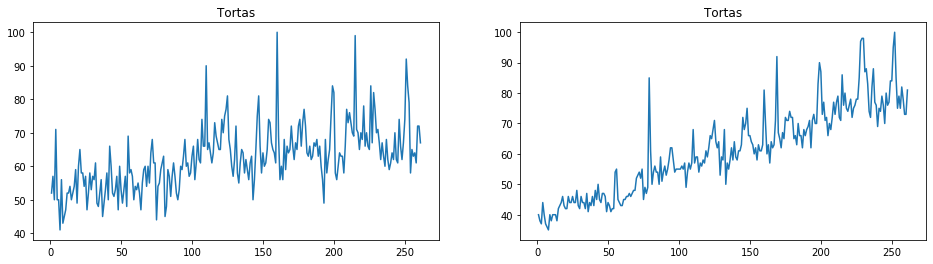

In [23]:
import matplotlib.pyplot as plt

x = [i+1 for i in range(len(iot['Tortas']['Tortas']))]

#for food in foods:
plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.title('Tortas')
plt.plot(x, iot['Tortas']['Tortas'].values);

plt.subplot(1,2,2)
plt.title('Tortas')
plt.plot(x, iot['Tacos']['Tacos'].values);

In [24]:
import numpy as np
from sklearn.linear_model import LinearRegression

def getTrendSlope(foods, iot):
    x = [i+1 for i in range(len(iot['Desayunos']['Desayunos']))]
    linreg = LinearRegression()

    slope = {}
    for food in foods:
        linreg.fit(np.array(x).reshape(-1,1), iot[food][food].values)
        slope[food] = linreg.coef_[0]

    return slope

In [25]:
slope = getTrendSlope(foods, iot)
slope

{'Cocina Económica': 0.055524733229392345,
 'Antojitos': 0.07527959449517754,
 'Pizza': 0.10219220982579759,
 'Hamburguesas': 0.05053084144950427,
 'Hot Dogs': 0.09394780002834756,
 'Sushi': 0.15221144565708922,
 'Tamales': 0.025006580679126086,
 'Mariscos': 0.11376340602452738,
 'Pescado': 0.019324248621432092,
 'Tacos': 0.17304891300679667,
 'Carne': 0.09254324687333372,
 'Asada': 0.049871423653998014,
 'Panuchos': 0.13367755347223628,
 'Cochinita': 0.03913580496891895,
 'Pollo': 0.07689472938222608,
 'Desayunos': 0.08419084644407099,
 'Tortas': 0.07300774157841808,
 'Mondongo': 0.07130283947867523,
 'Menudo': 0.05537692105209875,
 'Memelas': 0.12621067622383758,
 'Empanadas': -0.004555179838149041,
 'Chicharrón': 0.20697214516640683,
 'Gorditas': 0.07848286661132145,
 'Costillas': 0.023612151645844716,
 'Carnitas': 0.17278838560754853,
 'Doraditas': 0.08704382394827247,
 'Baguettes': -0.02251807155729241,
 'Parrilla': 0.14549442835833995,
 'Huaraches': 0.13285142513886922,
 'Rostice

Tortas slope: 0.07300774157841808
Tacos slope: 0.17304891300679667


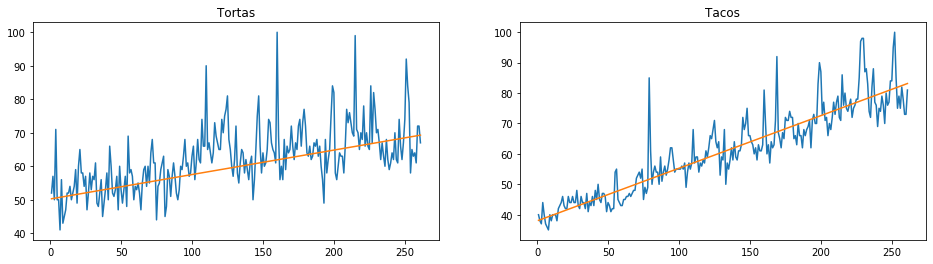

In [26]:
plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.plot(x, iot['Tortas']['Tortas'].values);
plt.title('Tortas')

print('Tortas slope:',slope['Tortas'])
yslope = [50.3 + i*slope['Tortas'] for i in range(len(iot['Tortas']['Tortas']))]
plt.plot(x, yslope);

plt.subplot(1,2,2)
plt.plot(x, iot['Tacos']['Tacos'].values);
plt.title('Tacos')

print('Tacos slope:',slope['Tacos'])
yslope = [38.145240200412616 + i*slope['Tacos'] for i in range(len(iot['Tacos']['Tacos']))]
plt.plot(x, yslope);

## Adding trending to the main dataframe df

In [27]:
def addSlopeToDf(df):
    df['slope'] = ''
    for key in slope:
        df['slope'].loc[key] = slope[key]
    df.slope = df.slope.astype('float64')
    
    return df

In [28]:
df = addSlopeToDf(df)
df.head()

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,InegiCount,GoogleTrend,slope
Index,,,
Cocina Económica,185,0,0.055525
Antojitos,156,27,0.075280
Pizza,31,62,0.102192
Hamburguesas,31,58,0.050531
Hot Dogs,23,40,0.093948


# User location geocode with GeoPy

In [29]:
from geopy.geocoders import Nominatim
#user_input = input('Introduce lugar:')

def userLocationGeocoding(string):
    geolocator = Nominatim(user_agent="food-business-recommender")
    return geolocator.geocode(string)

### As use case we are selecting 'unidad modelo' as the neiborghood

In [30]:
location = userLocationGeocoding('unidad modelo tampico tamaulipas')
location

Location(Almendro Fundadores Unidad Modelo, Avenida Arquitectos, Tampico, Tamaulipas, 89344, México, (22.2853942, -97.885855, 0.0))

# Yelp
In this section we are getting the satisfaction.

We are using the endpoint https://api.yelp.com/v3/businesses/search from the Yelp API https://www.yelp.com/developers

In [31]:
import requests
from bs4 import BeautifulSoup as bs
import json

## Searching for food business on the user location

In [32]:
def searchYelp(foods, location):
    api_key = os.getenv("YELP_API_KEY")
    endpoint = 'https://api.yelp.com/v3/businesses/search?'
    
    yelp_search = []
    for comida in foods:
        term = 'term={}&'.format(comida)
        print(term)
        
        latitude = 'latitude='+str(location.latitude)+'&'
        longitude = 'longitude='+str(location.longitude)+'&'
        locale = 'locale=es_MX&'
        radius = 'radius=3000&'
        limit = 'limit=50' 
        
        res = requests.get(endpoint+term+latitude+longitude+locale+radius+limit, headers={'Authorization':'Bearer '+api_key})
        
        soup = bs(res.content)
        yelp_json = json.loads(soup.findAll('p')[0].text)
        
        ydf = pd.DataFrame(yelp_json['businesses'])
        ydf['tipo'] = comida
        yelp_search.append(ydf)

    return yelp_search

In [33]:
yelp_search = searchYelp(foods, location)
yelp_search

term=Cocina Económica&
term=Antojitos&
term=Pizza&
term=Hamburguesas&
term=Hot Dogs&
term=Sushi&
term=Tamales&
term=Mariscos&
term=Pescado&
term=Tacos&
term=Carne&
term=Asada&
term=Panuchos&
term=Cochinita&
term=Pollo&
term=Desayunos&
term=Tortas&
term=Mondongo&
term=Menudo&
term=Memelas&
term=Empanadas&
term=Chicharrón&
term=Gorditas&
term=Costillas&
term=Carnitas&
term=Doraditas&
term=Baguettes&
term=Parrilla&
term=Huaraches&
term=Rosticería&
term=China&
term=Yucateca&
term=Tabasqueña&
term=Arrachera&
term=Pastor&
term=Birria&
term=Barbacoa&
term=Carnero&
term=Pozole&
term=Enchiladas&
term=Chilaquiles&


[Empty DataFrame
 Columns: [tipo]
 Index: [], Empty DataFrame
 Columns: [tipo]
 Index: [],                        id                    alias              name  \
 0  77jt2C-RMmBVn3d4YO3Ujg  chuck-e-cheeses-tampico  Chuck e Cheese's   
 
                                            image_url  is_closed  \
 0  https://s3-media3.fl.yelpcdn.com/bphoto/GLCEzI...      False   
 
                                                  url  review_count  \
 0  https://www.yelp.com.mx/biz/chuck-e-cheeses-ta...             1   
 
                                           categories  rating  \
 0  [{'alias': 'arcades', 'title': 'Sala de juegos...     4.0   
 
                                        coordinates transactions  \
 0  {'latitude': 22.27214, 'longitude': -97.873009}           []   
 
                                             location          phone  \
 0  {'address1': 'Av. Miguel Hidalgo S/N', 'addres...  +528338003030   
 
      display_phone     distance   tipo  
 0  01 833 800 3030  1

In [34]:
type(yelp_search[0])

pandas.core.frame.DataFrame

## Creating a dataframe with the Yelp searches

In [35]:
def getYelpDf(yelp_search):
    lugares = pd.concat(yelp_search, axis=0, sort=False)
    lugares.reset_index(inplace=True)

    ratings = dict(lugares.tipo.value_counts())
    for comida in foods:
        ratings[comida] = lugares[lugares.tipo == comida]['rating'].mean()

    yf = pd.concat(yelp_search, sort=False)
    yf.drop(columns = ['alias', 'display_phone', 'location', 'id', 'image_url', 'is_closed', 'phone', 'transactions', 'url'], inplace=True)
    yf.reset_index(inplace=True)
    return yf

In [36]:
yf = getYelpDf(yelp_search)
yf

,index,tipo,name,review_count,categories,rating,coordinates,distance,price
0,0,Pizza,Chuck e Cheese's,1.0,"[{'alias': 'arcades', 'title': 'Sala de juegos...",4.0,"{'latitude': 22.27214, 'longitude': -97.873009}",1979.691511,NaN
1,0,Hamburguesas,Marusha's,1.0,"[{'alias': 'burgers', 'title': 'Hamburguesas'}...",4.0,"{'latitude': 22.2638902126154, 'longitude': -9...",3413.126260,$
2,1,Hamburguesas,McDonalds,1.0,"[{'alias': 'burgers', 'title': 'Hamburguesas'}...",4.0,"{'latitude': 22.2756886931187, 'longitude': -9...",1663.131592,$$
3,2,Hamburguesas,7 Leguas,1.0,"[{'alias': 'tacos', 'title': 'Taquerías'}, {'a...",3.0,"{'latitude': 22.273538, 'longitude': -97.87504...",1724.937372,NaN
4,3,Hamburguesas,Carl's Jr,1.0,"[{'alias': 'burgers', 'title': 'Hamburguesas'}]",3.0,"{'latitude': 22.2657831010059, 'longitude': -9...",3433.658618,NaN
5,4,Hamburguesas,Applebee's Grill + Bar,1.0,"[{'alias': 'tradamerican', 'title': 'Cocina no...",1.0,"{'latitude': 22.272441, 'longitude': -97.875505}",1791.276534,$$
6,0,Sushi,Toyama Sushi Concept,1.0,"[{'alias': 'sushi', 'title': 'Sushi'}, {'alias...",4.0,"{'latitude': 22.2742, 'longitude': -97.86816}",1748.815983,NaN
7,1,Sushi,Kurai Sushi Bar,4.0,"[{'alias': 'sushi', 'title': 'Sushi'}]",4.0,"{'latitude': 22.257026, 'longitude': -97.874816}",3352.686655,$$
8,0,Mariscos,El Dorado,1.0,"[{'alias': 'buffets', 'title': 'Buffets'}, {'a...",4.0,"{'latitude': 22.3030333941498, 'longitude': -9...",2000.494185,NaN
9,0,Tacos,Tacos Ana,1.0,"[{'alias': 'streetvendors', 'title': 'Puestos ...",3.0,"{'latitude': 22.27917495095, 'longitude': -97....",793.579864,NaN


## Adding satisfaction to the main dataframe df

In [37]:
df['YelpRating'] = yf.groupby('tipo').mean().rating
df

,InegiCount,GoogleTrend,slope,YelpRating
Index,,,,
Cocina Económica,185,0,0.055525,NaN
Antojitos,156,27,0.075280,NaN
Pizza,31,62,0.102192,4.000
Hamburguesas,31,58,0.050531,3.000
Hot Dogs,23,40,0.093948,NaN
Sushi,2,8,0.152211,4.000
Tamales,39,100,0.025007,NaN
Mariscos,45,43,0.113763,4.000
Pescado,11,55,0.019324,NaN


# Score

In [38]:
df.head()

,InegiCount,GoogleTrend,slope,YelpRating
Index,,,,
Cocina Económica,185,0,0.055525,NaN
Antojitos,156,27,0.075280,NaN
Pizza,31,62,0.102192,4.0
Hamburguesas,31,58,0.050531,3.0
Hot Dogs,23,40,0.093948,NaN


## Changing column names in order to understand them better

In [39]:
df.rename(columns={'InegiCount':'Offer', 'GoogleTrend':'Demand', 'slope':'Trending', 'YelpRating':'Satisfaction'}, inplace=True)
df.head()

,Offer,Demand,Trending,Satisfaction
Index,,,,
Cocina Económica,185,0,0.055525,NaN
Antojitos,156,27,0.075280,NaN
Pizza,31,62,0.102192,4.0
Hamburguesas,31,58,0.050531,3.0
Hot Dogs,23,40,0.093948,NaN


In [40]:
for column in df.columns:
    df[column] = df[column]/df[column].max()
    
df.head()

,Offer,Demand,Trending,Satisfaction
Index,,,,
Cocina Económica,0.537791,0.00,0.268272,NaN
Antojitos,0.453488,0.27,0.363718,NaN
Pizza,0.090116,0.62,0.493749,0.888889
Hamburguesas,0.090116,0.58,0.244143,0.666667
Hot Dogs,0.066860,0.40,0.453915,NaN


## Calculating score

In [41]:
def calculateScore(df):
    #df['score'] = df.Demand/100 + df.Trending/df.Trending.max() - df.Satisfaction/5 - df.Offer/df.Offer.max()
    df['score'] = df.Demand + df.Trending - df.Satisfaction - df.Offer
    return df.sort_values(by='score', ascending=False).head(3)

In [42]:
df = calculateScore(df)
df

,Offer,Demand,Trending,Satisfaction,score
Index,,,,,
Carne,0.000000,0.80,0.447129,0.750000,0.497129
Pizza,0.090116,0.62,0.493749,0.888889,0.134743
Hamburguesas,0.090116,0.58,0.244143,0.666667,0.067360


# Yelp top competitors by location

In [43]:
from pandas.io.json import json_normalize

## Extracting coordinates from the Yelp dataframe

In [44]:
def flatLatLong(yf):
    yf[['latitude', 'longitude']] = json_normalize(yf.coordinates)
    return yf

In [45]:
yf = flatLatLong(yf)
yf

,index,tipo,name,review_count,categories,rating,coordinates,distance,price,latitude,longitude
0,0,Pizza,Chuck e Cheese's,1.0,"[{'alias': 'arcades', 'title': 'Sala de juegos...",4.0,"{'latitude': 22.27214, 'longitude': -97.873009}",1979.691511,NaN,22.272140,-97.873009
1,0,Hamburguesas,Marusha's,1.0,"[{'alias': 'burgers', 'title': 'Hamburguesas'}...",4.0,"{'latitude': 22.2638902126154, 'longitude': -9...",3413.126260,$,22.263890,-97.862185
2,1,Hamburguesas,McDonalds,1.0,"[{'alias': 'burgers', 'title': 'Hamburguesas'}...",4.0,"{'latitude': 22.2756886931187, 'longitude': -9...",1663.131592,$$,22.275689,-97.873556
3,2,Hamburguesas,7 Leguas,1.0,"[{'alias': 'tacos', 'title': 'Taquerías'}, {'a...",3.0,"{'latitude': 22.273538, 'longitude': -97.87504...",1724.937372,NaN,22.273538,-97.875044
4,3,Hamburguesas,Carl's Jr,1.0,"[{'alias': 'burgers', 'title': 'Hamburguesas'}]",3.0,"{'latitude': 22.2657831010059, 'longitude': -9...",3433.658618,NaN,22.265783,-97.860078
5,4,Hamburguesas,Applebee's Grill + Bar,1.0,"[{'alias': 'tradamerican', 'title': 'Cocina no...",1.0,"{'latitude': 22.272441, 'longitude': -97.875505}",1791.276534,$$,22.272441,-97.875505
6,0,Sushi,Toyama Sushi Concept,1.0,"[{'alias': 'sushi', 'title': 'Sushi'}, {'alias...",4.0,"{'latitude': 22.2742, 'longitude': -97.86816}",1748.815983,NaN,22.274200,-97.868160
7,1,Sushi,Kurai Sushi Bar,4.0,"[{'alias': 'sushi', 'title': 'Sushi'}]",4.0,"{'latitude': 22.257026, 'longitude': -97.874816}",3352.686655,$$,22.257026,-97.874816
8,0,Mariscos,El Dorado,1.0,"[{'alias': 'buffets', 'title': 'Buffets'}, {'a...",4.0,"{'latitude': 22.3030333941498, 'longitude': -9...",2000.494185,NaN,22.303033,-97.882029
9,0,Tacos,Tacos Ana,1.0,"[{'alias': 'streetvendors', 'title': 'Puestos ...",3.0,"{'latitude': 22.27917495095, 'longitude': -97....",793.579864,NaN,22.279175,-97.882072


## Looking for the top competitors

In [46]:
def getTopYf(yf):
    top_yf = pd.DataFrame(columns = yf.columns)
    top_types = df.sort_values(by='score', ascending=False).head().index
    
    for top in top_types:
        top_yf = pd.concat([top_yf, yf[yf.tipo==top].sort_values(by='rating', ascending=False).head(10)])

    return top_yf

In [47]:
top_yf = getTopYf(yf)
top_yf

,index,tipo,name,review_count,categories,rating,coordinates,distance,price,latitude,longitude
13,0,Carne,El Asador,10.0,"[{'alias': 'steak', 'title': 'Parrilla'}]",4.5,"{'latitude': 22.2626292435619, 'longitude': -9...",3721.330388,$$,22.262629,-97.859346
15,2,Carne,McDonalds,1.0,"[{'alias': 'burgers', 'title': 'Hamburguesas'}...",4.0,"{'latitude': 22.2756886931187, 'longitude': -9...",1663.131592,$$,22.275689,-97.873556
14,1,Carne,Tacos Ana,1.0,"[{'alias': 'streetvendors', 'title': 'Puestos ...",3.0,"{'latitude': 22.27917495095, 'longitude': -97....",793.579864,NaN,22.279175,-97.882072
16,3,Carne,Sarape Oriental,1.0,"[{'alias': 'tacos', 'title': 'Taquerías'}]",2.0,"{'latitude': 22.3082363584824, 'longitude': -9...",2589.637945,NaN,22.308236,-97.880947
0,0,Pizza,Chuck e Cheese's,1.0,"[{'alias': 'arcades', 'title': 'Sala de juegos...",4.0,"{'latitude': 22.27214, 'longitude': -97.873009}",1979.691511,NaN,22.272140,-97.873009
1,0,Hamburguesas,Marusha's,1.0,"[{'alias': 'burgers', 'title': 'Hamburguesas'}...",4.0,"{'latitude': 22.2638902126154, 'longitude': -9...",3413.126260,$,22.263890,-97.862185
2,1,Hamburguesas,McDonalds,1.0,"[{'alias': 'burgers', 'title': 'Hamburguesas'}...",4.0,"{'latitude': 22.2756886931187, 'longitude': -9...",1663.131592,$$,22.275689,-97.873556
3,2,Hamburguesas,7 Leguas,1.0,"[{'alias': 'tacos', 'title': 'Taquerías'}, {'a...",3.0,"{'latitude': 22.273538, 'longitude': -97.87504...",1724.937372,NaN,22.273538,-97.875044
4,3,Hamburguesas,Carl's Jr,1.0,"[{'alias': 'burgers', 'title': 'Hamburguesas'}]",3.0,"{'latitude': 22.2657831010059, 'longitude': -9...",3433.658618,NaN,22.265783,-97.860078
5,4,Hamburguesas,Applebee's Grill + Bar,1.0,"[{'alias': 'tradamerican', 'title': 'Cocina no...",1.0,"{'latitude': 22.272441, 'longitude': -97.875505}",1791.276534,$$,22.272441,-97.875505


In [54]:
def getTopCompetitors(top_yf):
    top_yf_list = []
    for tipo in top_yf.tipo.unique():
        toadd = {'tipo': tipo}
        for index in top_yf[top_yf.tipo==tipo].index:
            toadd['name'] = top_yf.name.loc[index]
            toadd['coords'] = [top_yf.latitude.loc[index], top_yf.longitude.loc[index]]
            top_yf_list.append(toadd)

    return top_yf_list

In [55]:
getTopCompetitors(top_yf)

[{'tipo': 'Carne',
  'name': 'Sarape Oriental',
  'coords': [22.3082363584824, -97.8809468065949]},
 {'tipo': 'Carne',
  'name': 'Sarape Oriental',
  'coords': [22.3082363584824, -97.8809468065949]},
 {'tipo': 'Carne',
  'name': 'Sarape Oriental',
  'coords': [22.3082363584824, -97.8809468065949]},
 {'tipo': 'Carne',
  'name': 'Sarape Oriental',
  'coords': [22.3082363584824, -97.8809468065949]},
 {'tipo': 'Pizza',
  'name': "Chuck e Cheese's",
  'coords': [22.27214, -97.873009]},
 {'tipo': 'Hamburguesas',
  'name': "Applebee's Grill + Bar",
  'coords': [22.272441, -97.875505]},
 {'tipo': 'Hamburguesas',
  'name': "Applebee's Grill + Bar",
  'coords': [22.272441, -97.875505]},
 {'tipo': 'Hamburguesas',
  'name': "Applebee's Grill + Bar",
  'coords': [22.272441, -97.875505]},
 {'tipo': 'Hamburguesas',
  'name': "Applebee's Grill + Bar",
  'coords': [22.272441, -97.875505]},
 {'tipo': 'Hamburguesas',
  'name': "Applebee's Grill + Bar",
  'coords': [22.272441, -97.875505]}]

# Foursquare

In [60]:
import foursquare

In [61]:
def getFsResults(top_yf):
    client_id = os.getenv("FS_CLIENT_ID")
    client_secret = os.getenv("FS_CLIENT_SECRET")
    client = foursquare.Foursquare(client_id=client_id, client_secret=client_secret)

    fs_results = {}
    comida = top_yf.tipo.unique()[0]
    #for comida in top_yf.tipo.unique():
    #    print(comida)
    fs_results[comida] = client.venues.search(params={'query': comida, 'intent':'checkin', 'll': str(location.latitude)+', '+str(location.longitude), 'radius':3000, 'limit':10})

    return fs_results

In [62]:
def getFsResults(top_yf):
    client_id = os.getenv("FS_CLIENT_ID")
    client_secret = os.getenv("FS_CLIENT_SECRET")
    client = foursquare.Foursquare(client_id=client_id, client_secret=client_secret)

    fs_results = []
    comida = top_yf.tipo.unique()[0]
    #for comida in top_yf.tipo.unique():
    #    print(comida)
    fs_results.append(client.venues.search(params={'query': comida, 'intent':'checkin', 'll': str(location.latitude)+', '+str(location.longitude), 'radius':3000, 'limit':10}))

    return fs_results[0]['venues']

In [63]:
fs_results = getFsResults(top_yf)
fs_results

[{'id': '51bbd147498e3b192c91d25b',
  'name': 'Carne Asada El Arbol',
  'location': {'lat': 22.283576,
   'lng': -97.886253,
   'labeledLatLngs': [{'label': 'display',
     'lat': 22.283576,
     'lng': -97.886253}],
   'distance': 206,
   'cc': 'MX',
   'country': 'México',
   'formattedAddress': ['México']},
  'categories': [{'id': '4bf58dd8d48988d16c941735',
    'name': 'Burger Joint',
    'pluralName': 'Burger Joints',
    'shortName': 'Burgers',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/burger_',
     'suffix': '.png'},
    'primary': True}],
  'referralId': 'v-1583361468',
  'hasPerk': False},
 {'id': '5ae7ce0db9b37b002c9ca48a',
  'name': 'Carne Asada La Curva',
  'location': {'lat': 22.30518146461432,
   'lng': -97.88176138646172,
   'labeledLatLngs': [{'label': 'display',
     'lat': 22.30518146461432,
     'lng': -97.88176138646172}],
   'distance': 2242,
   'postalCode': '89318',
   'cc': 'MX',
   'city': 'Tampico',
   'state': 'Tamaulipas',
   'coun

In [64]:
'''
def getFsLocs(fs_results):
    fs_locs = {}
    for result in fs_results:
        result_locs = []
        for i in range(len(fs_results[result]['venues'])):
            loc = {}
            loc[fs_results[result]['venues'][i]['name']] = []
            loc[fs_results[result]['venues'][i]['name']].append(fs_results[result]['venues'][i]['location']['lat'])
            loc[fs_results[result]['venues'][i]['name']].append(fs_results[result]['venues'][i]['location']['lng'])
            result_locs.append(loc)
        fs_locs[result] = result_locs

    return fs_locs
'''

"\ndef getFsLocs(fs_results):\n    fs_locs = {}\n    for result in fs_results:\n        result_locs = []\n        for i in range(len(fs_results[result]['venues'])):\n            loc = {}\n            loc[fs_results[result]['venues'][i]['name']] = []\n            loc[fs_results[result]['venues'][i]['name']].append(fs_results[result]['venues'][i]['location']['lat'])\n            loc[fs_results[result]['venues'][i]['name']].append(fs_results[result]['venues'][i]['location']['lng'])\n            result_locs.append(loc)\n        fs_locs[result] = result_locs\n\n    return fs_locs\n"

In [65]:
def getFsLocs(fs_results):
    fs_locs = []
    for venue in fs_results:
        fs_locs.append({'name':venue['name'], 'coords':[venue['location']['lat'], venue['location']['lng']]})

    return fs_locs

In [66]:
fs_locs = getFsLocs(fs_results)
fs_locs

[{'name': 'Carne Asada El Arbol', 'coords': [22.283576, -97.886253]},
 {'name': 'Carne Asada La Curva',
  'coords': [22.30518146461432, -97.88176138646172]},
 {'name': 'Tacos de carne asada El Tío', 'coords': [22.281633, -97.872621]},
 {'name': 'Carne Mart', 'coords': [22.277213034957917, -97.85357491977284]},
 {'name': 'Carne Mart', 'coords': [22.318098, -97.878915]},
 {'name': 'Carnes Campos', 'coords': [22.265688, -97.86897]},
 {'name': 'carnes victoria',
  'coords': [22.309574350711213, -97.86769864423096]},
 {'name': 'Carnes Lalo', 'coords': [22.296935, -97.855376]},
 {'name': 'Carnes La Torrada', 'coords': [22.257205, -97.872798]},
 {'name': 'CarneMart', 'coords': [22.2771106, -97.8514408]}]

## Folium map

In [67]:
import folium

In [74]:
top_types = df.sort_values(by='score', ascending=False).head().index

mapa=folium.Map(location=[location.latitude, location.longitude], tiles='openstreetmap',zoom_start=12)

five_colors = ['red', 'orange', 'green']
colors = dict(zip(top_yf.tipo.unique(), five_colors))

folium.Circle([location.latitude, location.longitude], radius=3000, icon=folium.Icon()).add_to(mapa)

for loc in fs_locs:
    folium.Marker(list(loc['coords']), popup='<b>'+ loc['name'] +'</b>', tooltip=top_yf.tipo.unique()[0], icon=folium.Icon(color='gray', icon='info-sign')).add_to(mapa)
    
for i in top_yf.index:
    folium.Marker(list(top_yf.loc[i][['latitude', 'longitude']]), popup='<b>'+top_yf.loc[i]['name']+'</b>', tooltip=top_yf.loc[i]['tipo'], icon=folium.Icon(color=colors[top_yf.loc[i]['tipo']], icon='info-sign')).add_to(mapa)

mapa